# Interactions

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import theano
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
%matplotlib inline

In [3]:
sns.set()

## Building an Interaction

### 7.1

In [4]:
d = pd.read_csv('Data/rugged.csv', sep=';')

# make log version of outcome
d["log_gdp"] = np.log(d["rgdppc_2000"])

# extract countries with GDP data
dd = d[np.isfinite(d["rgdppc_2000"])]

# split countries into Africa and not-Africa
d_A1 = dd[dd["cont_africa"] == 1]
d_A0 = dd[dd["cont_africa"] == 0]

### 7.2

In [5]:
# African Nations
with pm.Model() as m7_1:
    sigma = pm.Uniform("sigma", 0, 10)
    bR = pm.Normal("bR", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    mu = pm.Deterministic("mu", a + bR*d_A1["rugged"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=d_A1["log_gdp"])
    trace7_1 = pm.sample(draws=1000, tune=1000)
    
# non-African Nations
with pm.Model() as m7_2:
    sigma = pm.Uniform("sigma", 0, 10)
    bR = pm.Normal("bR", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    mu = pm.Deterministic("mu", a + bR*d_A0["rugged"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=d_A0["log_gdp"])
    trace7_2 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:08<00:00, 473.29draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 894.29draws/s] 


### 7.3

In [6]:
model_rugged = theano.shared(dd["rugged"].values)
model_cont_africa = theano.shared(dd["cont_africa"].values)

In [7]:
with pm.Model() as m7_3:
    sigma = pm.Uniform("sigma", 0, 10)
    bR = pm.Normal("bR", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    mu = pm.Deterministic("mu", a + bR*model_rugged)
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=dd["log_gdp"])
    trace7_3 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 528.05draws/s]


### 7.4

In [8]:
with pm.Model() as m7_4:
    sigma = pm.Uniform("sigma", 0, 10)
    bR = pm.Normal("bR", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    mu = pm.Deterministic("mu", a + bR*model_rugged + bA*model_cont_africa)
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=dd["log_gdp"])
    trace7_4 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 633.19draws/s]


### 7.5

In [9]:
(pm.compare({m7_3: trace7_3,
             m7_4: trace7_4},
            method='pseudo-BMA')
            .join(pd.Series(["m7_3", "m7_4"], name="model"))
            .set_index("model")
            .sort_values("WAIC"))

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m7_4,476.01,4.12,0,1,14.81,0,1
m7_3,539.76,2.73,63.75,0,12.92,14.58,0


### 7.6

In [10]:
rugged_seq = np.arange(-8, 8, 0.25)
model_rugged.set_value(rugged_seq)

# compute mu over samples, fixing cont_africa=0
model_cont_africa.set_value(np.repeat(0, len(rugged_seq)))
mu_NotAfrica = pm.sample_ppc(trace7_4, samples=10000, model=m7_4, vars=[m7_4.mu])["mu"]

# compute mu over samples, fixing cont_africa=1
model_cont_africa.set_value(np.repeat(1, len(rugged_seq)))
mu_Africa = pm.sample_ppc(trace7_4, samples=10000, model=m7_4, vars=[m7_4.mu])["mu"]


mu_NotAfrica_mean = mu_NotAfrica.mean(0)
mu_NotAfrica_pi = pm.hpd(mu_NotAfrica, alpha=0.03)
mu_Africa_mean = mu_Africa.mean(0)
mu_Africa_pi = pm.hpd(mu_Africa, alpha=0.03)

100%|██████████| 10000/10000 [00:01<00:00, 6223.80it/s]


### 7.7

In [11]:
model_rugged.set_value(dd["rugged"].values)
model_cont_africa.set_value(dd["cont_africa"].values)

In [12]:
with pm.Model() as m7_5:
    sigma = pm.Uniform("sigma", 0, 10)
    bAR = pm.Normal("bAR", mu=0, sd=1)
    bR = pm.Normal("bR", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    gamma = pm.Deterministic("gamma", bR + bAR*model_cont_africa)
    mu = pm.Deterministic("mu", a + gamma*model_rugged + bA*model_cont_africa)
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=dd["log_gdp"])
    trace7_5 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, bR, bAR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:08<00:00, 467.92draws/s]


### 7.8

In [13]:
(pm.compare({m7_3: trace7_3,
             m7_4: trace7_4,
             m7_5: trace7_5},
            method='pseudo-BMA')
            .join(pd.Series(["m7_3", "m7_4", "m7_5"], name="model"))
            .set_index("model")
            .sort_values("WAIC"))

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m7_5,468.76,4.74,0,0.97,14.51,0,1
m7_4,476.01,4.12,7.25,0.03,14.81,5.93,1
m7_3,539.76,2.73,70.99,0,12.92,14.58,0


### 7.9

In [14]:
with pm.Model() as m7_5b:
    sigma = pm.Uniform("sigma", 0, 10)
    bAR = pm.Normal("bAR", mu=0, sd=1)
    bR = pm.Normal("bR", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=8, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bA*dd["cont_africa"] +\
                                bR*dd["rugged"] +\
                                bAR*dd["rugged"]*dd["cont_africa"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=dd["log_gdp"])
    trace7_5b = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, bR, bAR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:11<00:00, 359.48draws/s]


### 7.10

In [15]:
rugged_seq = np.arange(-1, 8, 0.25)
model_rugged.set_value(rugged_seq)

model_cont_africa.set_value(np.repeat(1, len(rugged_seq)))
mu_Africa = pm.sample_ppc(trace7_5, samples=10000, model=m7_5, vars=[m7_5.mu])["mu"]
mu_Africa_mean = mu_Africa.mean(0)
mu_Africa_pi = pm.hpd(mu_Africa, alpha=0.03)

model_cont_africa.set_value(np.repeat(0, len(rugged_seq)))
mu_NotAfrica = pm.sample_ppc(trace7_5, samples=10000, model=m7_5, vars=[m7_5.mu])["mu"]
mu_NotAfrica_mean = mu_NotAfrica.mean(0)
mu_NotAfrica_pi = pm.hpd(mu_NotAfrica, alpha=0.03)

100%|██████████| 10000/10000 [00:02<00:00, 4213.96it/s]


### 7.11

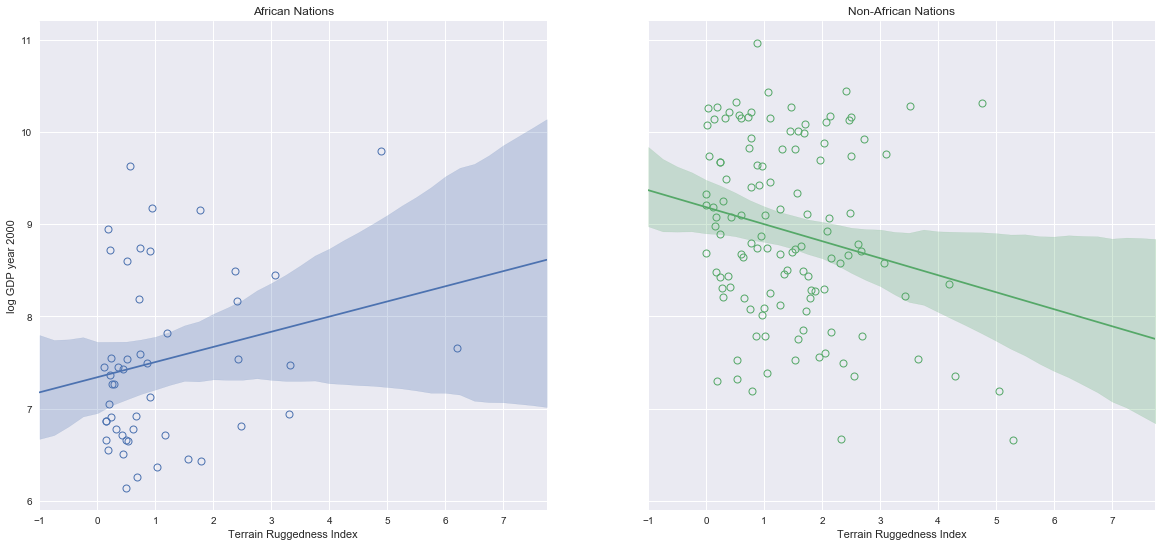

In [16]:
f, axs = plt.subplots(1, 2, sharey=True)
f.set_size_inches(20, 9)

d_A1 = dd[dd["cont_africa"] == 1]
axs[0].plot(d_A1["rugged"], d_A1["log_gdp"], "o", mew=1, mec="C0", mfc="None")
axs[0].plot(rugged_seq, mu_Africa_mean, color="C0")
axs[0].fill_between(rugged_seq, mu_Africa_pi[:,0], mu_Africa_pi[:,1], alpha=0.25, color="C0")
axs[0].set_title("African Nations")
axs[0].set_xlabel("Terrain Ruggedness Index")

d_A0 = dd[dd["cont_africa"] == 0]
axs[1].plot(d_A0["rugged"], d_A0["log_gdp"], "o", mew=1, mec="C1", mfc="None")
axs[1].plot(rugged_seq, mu_NotAfrica_mean, color="C1")
axs[1].fill_between(rugged_seq, mu_NotAfrica_pi[:,0], mu_NotAfrica_pi[:,1], alpha=0.25, color="C1")
axs[1].set_title("Non-African Nations")
axs[1].set_xlabel("Terrain Ruggedness Index")

axs[0].set_xlim((-1, 7.75))
axs[1].set_xlim((-1, 7.75))
axs[0].set_ylabel("log GDP year 2000");

### 7.12

In [17]:
pm.summary(trace7_5, varnames=["a", "bA", "bR", "bAR", "sigma"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,9.183198,0.135810,0.004599,8.910716,9.439973,831.890141,1.000243
bA,-1.842678,0.216912,0.006800,-2.252493,-1.420905,921.914463,0.999865
bR,-0.184821,0.074306,0.002511,-0.326914,-0.044734,739.540267,1.000653
bAR,0.349265,0.127654,0.003870,0.102536,0.598494,915.736829,1.000648
sigma,0.949809,0.050108,0.001140,0.853107,1.044561,2020.123604,1.003637


### 7.13

In [18]:
gamma_Africa = trace7_5["bR"] + trace7_5["bAR"]*1
gamma_notAfrica = trace7_5["bR"] + trace7_5["bAR"]*0

### 7.14

In [19]:
(gamma_Africa.mean(),
 gamma_notAfrica.mean())

(0.1644441389944332, -0.1848210460848439)

### 7.15

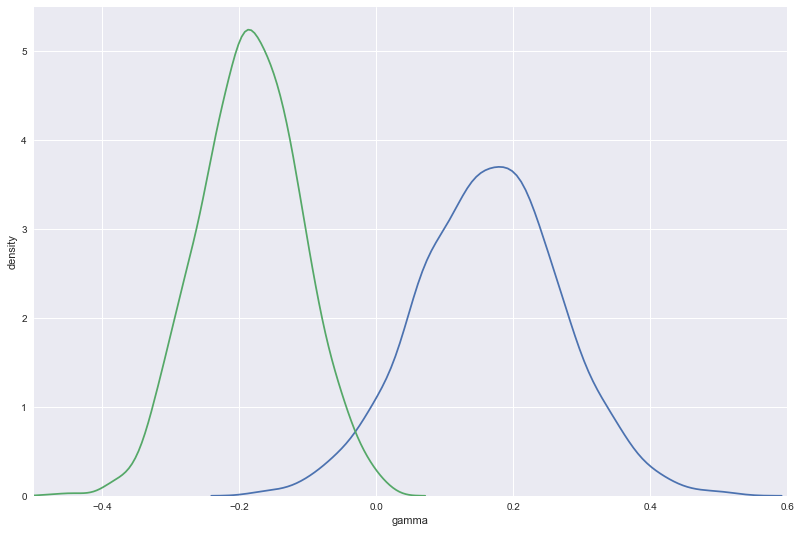

In [20]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
sns.kdeplot(gamma_Africa, ax=ax)
sns.kdeplot(gamma_notAfrica, ax=ax)
ax.set_xlim((-0.5, 0.6))
ax.set_ylim((0, 5.5))
ax.set_xlabel("gamma")
ax.set_ylabel("density");

### 7.16

In [21]:
diff = gamma_Africa - gamma_notAfrica
sum(diff < 0)/len(diff)

0.0035

## Symmetry of the Linear Interaction

### 7.17

100%|██████████| 10000/10000 [00:01<00:00, 5782.06it/s]


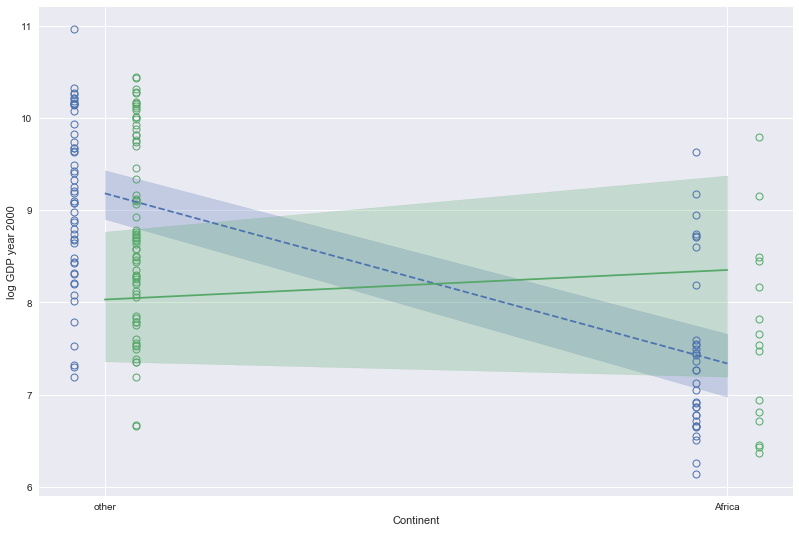

In [22]:
# get minimum and maximum rugged values
q_rugged = (dd["rugged"].min(), dd["rugged"].max())

# compute lines and confidence intervals
model_rugged.set_value(np.repeat(q_rugged[0], 2))
model_cont_africa.set_value([0, 1])
mu_ruggedlo = pm.sample_ppc(trace7_5, samples=10000, model=m7_5, vars=[m7_5.mu])["mu"]
mu_ruggedlo_mean = mu_ruggedlo.mean(0)
mu_ruggedlo_pi = pm.hpd(mu_ruggedlo)

model_rugged.set_value(np.repeat(q_rugged[1], 2))
model_cont_africa.set_value([0, 1])
mu_ruggedhi = pm.sample_ppc(trace7_5, samples=10000, model=m7_5, vars=[m7_5.mu])["mu"]
mu_ruggedhi_mean = mu_ruggedhi.mean(0)
mu_ruggedhi_pi = pm.hpd(mu_ruggedhi)

# plot it all, splitting points at median
data = (dd
        .assign(more_rugged=lambda df: df["rugged"] > np.median(df["rugged"]))
        .set_index(["more_rugged"]))

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(data.loc[False]["cont_africa"] - 0.05, data.loc[False]["log_gdp"], "o", mew=1, mec="C0", mfc="None")
ax.plot(data.loc[True]["cont_africa"] + 0.05, data.loc[True]["log_gdp"], "o", mew=1, mec="C1", mfc="None")

ax.plot([0, 1], mu_ruggedlo_mean, "--", color="C0")
ax.fill_between([0, 1], mu_ruggedlo_pi[:,0], mu_ruggedlo_pi[:,1], alpha=0.25, color="C0")

ax.plot([0, 1], mu_ruggedhi_mean, color="C1")
ax.fill_between([0, 1], mu_ruggedhi_pi[:,0], mu_ruggedhi_pi[:,1], alpha=0.25, color="C1")

ax.set_xlabel("Continent")
ax.set_ylabel("log GDP year 2000")
ax.set_xticks([0, 1])
ax.set_xticklabels(["other", "Africa"]);

## Continuous Interactions

### 7.18

In [23]:
d = pd.read_csv('Data/tulips.csv', sep=';')
d.head()

,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


### 7.19

In [24]:
with pm.Model() as m7_6:
    sigma = pm.Uniform("sigma", 0, 100)
    bS = pm.Normal("bS", mu=0, sd=100)
    bW = pm.Normal("bW", mu=0, sd=100)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bW*d["water"] +\
                                bS*d["shade"])
    blooms = pm.Normal("blooms", mu=mu, sd=sigma, observed=d["blooms"])
    trace7_6 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m7_7:
    sigma = pm.Uniform("sigma", 0, 100)
    bWS = pm.Normal("bWS", mu=0, sd=100) 
    bS = pm.Normal("bS", mu=0, sd=100)
    bW = pm.Normal("bW", mu=0, sd=100)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bW*d["water"] +\
                                bS*d["shade"] +\
                                bWS*d["water"]*d["shade"])
    blooms = pm.Normal("blooms", mu=mu, sd=sigma, observed=d["blooms"])
    trace7_7 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bW, bS, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:08<00:00, 466.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bW, bS, bWS, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:14<00:00, 273.52draws/s]
The number of effective samples is smaller than 25% for some parameters.


### 7.20

Since I'm not using MAP but MCMC, I'm not implementing the MAP optimisation

### 7.21

In [25]:
(pm.summary(trace7_6, varnames=["a", "bW", "bS", "sigma"])[["mean"]]
 .join(pm.summary(trace7_7, varnames=["a", "bW", "bS", "sigma", "bWS"])[["mean"]],
       lsuffix="_7_6", rsuffix="_7_7", how="outer"))

,mean_7_6,mean_7_7
a,53.297673,-70.305331
bS,-38.707854,28.451975
bW,76.362435,144.495233
bWS,NaN,-36.458833
sigma,63.840854,52.993755


### 7.22

In [26]:
(pm.compare({m7_6: trace7_6,
             m7_7: trace7_7},
            method='pseudo-BMA')
            .join(pd.Series(["m7_6", "m7_7"], name="model"))
            .set_index("model")
            .sort_values("WAIC"))

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m7_7,294.37,4.24,0,0.99,7.18,0,1
m7_6,303.43,3.52,9.07,0.01,6.83,3.8,1


### 7.23

In [27]:
d["shade_c"] = d["shade"] - d["shade"].mean()
d["water_c"] = d["water"] - d["water"].mean()

### 7.24

There isn't a way to set starting parameters that I can find, you could encode them in the priors though.

In [28]:
model_water_c = theano.shared(d["water_c"].values)
model_shade_c = theano.shared(d["shade_c"].values)

In [29]:
with pm.Model() as m7_8:
    sigma = pm.Uniform("sigma", 0, 100)
    bS = pm.Normal("bS", mu=0, sd=100)
    bW = pm.Normal("bW", mu=0, sd=100)
    a = pm.Normal("a", mu=130, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bW*model_water_c +\
                                bS*model_shade_c)
    blooms = pm.Normal("blooms", mu=mu, sd=sigma, observed=d["blooms"])
    trace7_8 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m7_9:
    sigma = pm.Uniform("sigma", 0, 100)
    bWS = pm.Normal("bWS", mu=0, sd=100) 
    bS = pm.Normal("bS", mu=0, sd=100)
    bW = pm.Normal("bW", mu=0, sd=100)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bW*model_water_c +\
                                bS*model_shade_c +\
                                bWS*model_water_c*model_shade_c)
    blooms = pm.Normal("blooms", mu=mu, sd=sigma, observed=d["blooms"])
    trace7_9 = pm.sample(draws=1000, tune=1000)
    
(pm.summary(trace7_8, varnames=["a", "bW", "bS", "sigma"])[["mean"]]
 .join(pm.summary(trace7_9, varnames=["a", "bW", "bS", "sigma", "bWS"])[["mean"]],
       lsuffix="_7_8", rsuffix="_7_9", how="outer"))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bW, bS, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 700.08draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6649234514394986, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bW, bS, bWS, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 677.02draws/s]


,mean_7_8,mean_7_9
a,128.372834,127.644027
bS,-40.823440,-40.879249
bW,75.002701,74.422227
bWS,NaN,-51.566690
sigma,64.495243,51.952910


### 7.25

In [30]:
k = pm.summary(trace7_7, varnames=["a", "bW", "bS", "bWS"])["mean"]
k["a"] + k["bW"]*2 + k["bS"]*2 + k["bWS"]*2*2

129.75375374388773

### 7.26

In [31]:
k = pm.summary(trace7_9, varnames=["a", "bW", "bS", "bWS"])["mean"]
k["a"] + k["bW"]*0 + k["bS"]*0 + k["bWS"]*0*0

127.64402736702975

### 7.27

In [32]:
(pm.summary(trace7_9, varnames=["a", "bW", "bS", "bWS", "sigma"], alpha=0.11)
 .round(2)
 [["mean", "sd", "hpd_5.5", "hpd_94.5"]])

,mean,sd,hpd_5.5,hpd_94.5
a,127.64,10.05,111.07,142.67
bW,74.42,12.03,55.35,93.42
bS,-40.88,12.55,-61.42,-21.57
bWS,-51.57,15.21,-76.64,-28.14
sigma,51.95,8.14,38.94,63.04


### 7.28

100%|██████████| 10000/10000 [00:03<00:00, 3255.41it/s]


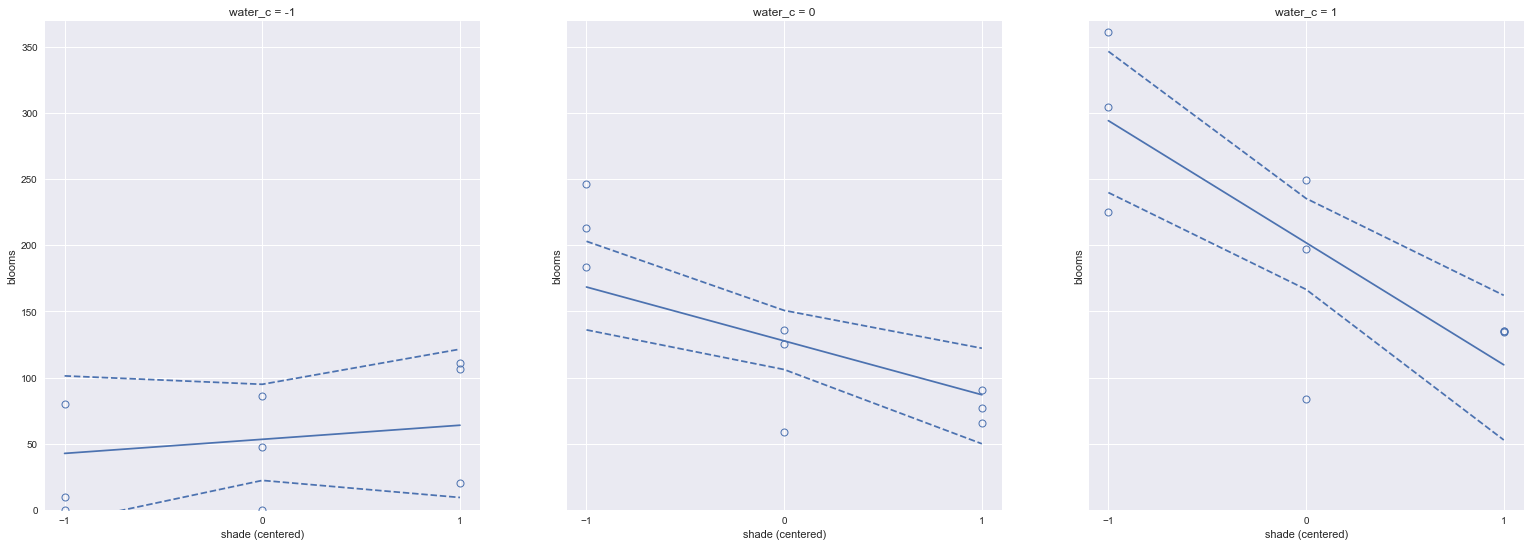

In [33]:
f, axs = plt.subplots(1, 3, sharey=True)
f.set_size_inches(26.5, 9)

shade_seq = np.arange(-1, 2)
model_shade_c.set_value(shade_seq)

for w, ax in zip(range(-1, 2), axs):
    dt = d[d["water_c"] == w]
    ax.plot(dt["shade_c"], dt["blooms"], "o", mew=1, mec="C0", mfc="None")
    ax.set_xticks(shade_seq)
    ax.set_ylim(0, 370)
    ax.set_title("water_c = {}".format(w))
    ax.set_xlabel("shade (centered)")
    ax.set_ylabel("blooms")
    model_water_c.set_value(np.repeat(w, len(shade_seq)))
    mu = pm.sample_ppc(trace7_9, samples=10000, model=m7_9, vars=[m7_9.mu])["mu"]
    mu_mean = mu.mean(0)
    mu_pi = pm.hpd(mu, alpha=0.03)
    ax.plot(shade_seq, mu_mean, color="C0")
    ax.plot(shade_seq, mu_pi[:, 0], "--", color="C0")
    ax.plot(shade_seq, mu_pi[:, 1], "--", color="C0")

## Interactions in Design Formulas

### 7.29

In [34]:
m7_x = smf.ols("blooms ~ shade + water + shade * water", data=d).fit()

### 7.30

In [35]:
m7_x = smf.ols("blooms ~ shade * water", data=d).fit()

### 7.31

In [36]:
m7_x = smf.ols("blooms ~ shade * water - water", data=d).fit()

### 7.32

In [37]:
m7_x = smf.ols('blooms ~ shade * water * bed', data=d).fit()

### 7.33

In [38]:
y = pd.DataFrame({"y": [1], "x": [1], "z": [1], "w": [1]})

In [39]:
(smf.ols('y ~ x * z * w', data=y)
 .fit()
 .params
 .index)

Index(['Intercept', 'x', 'z', 'x:z', 'w', 'x:w', 'z:w', 'x:z:w'], dtype='object')